<a href="https://colab.research.google.com/github/bayu-wilson/bayesian_AB_testing/blob/main/Bayesian_AB_testing_pyMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian A/B Testing in Marketing Campaign using PyMC
### Written by Bayu Wilson

Note that this notebook is largely based off of the tutorial on the PyMC website: [Introduction to Bayesian A/B testing](https://www.pymc.io/projects/examples/en/latest/causal_inference/bayesian_ab_testing_introduction.html#references)

## Background

In this hypothetical project, I am working for a marketing team for a company that sells products online. We are seeking ways to improve the current marketing campaign to address 3 important key performance indicators (KPIs):
1.   Bernoulli conversion probability (probability of customer buying something)
2.   Value conversion (average amount spent when paying)
3.   Total revenue

The marketing team decides that a larger "BUY NOW" button next to higher cost products may help improve these KPIs. The plan is to run a series of A/B tests, with and without the larger "BUY NOW" button, and then use Bayesian inference to quantify the probability that the new variant improves the KPI and, if it does, by how much.

We will be using PyMC. PyMC is a probabilistic programming library for Python that allows users to build Bayesian models with a simple Python API and fit them using Markov chain Monte Carlo (MCMC) methods.

### Bernoulli conversion probability
Let $\theta_A, \theta_B$ be the true conversion rates for variants A and B respectively. The beta distribution is used to set the prior Bernoulli probabilities. Then the binomial distribution will be the likelihood. Using Bayes theorem:

$$ P(\theta_i|y) \propto P(\theta_i)P(y|\theta_i)$$
$$ \mathrm{Posterior} \propto \mathrm{Prior} \times \mathrm{Likelihood}$$
$$  \theta^\mathrm{estimate}_i  \propto \mathrm{Beta}(\alpha,\beta) \times \mathrm{Binomial}(N,y,\theta_i)$$

where $\alpha$ and $\beta$ set how well we know the prior and the Binomial distribution is used for the likelihood because we are dealing with the number of successes ($y$) in a sequence of $N_i$ independent experiments with a boolean outcome.

A good way to quantify the difference between the variants is to use the relative uplift in bernoulli covergence rates:

$$ \mathrm{reluplift}_B^\mathrm{Bern} = \theta^\mathrm{estimate}_B/\theta^\mathrm{estimate}_A-1$$



### Value conversion estimate

Next, let $\lambda_A$ and $\lambda_B$ be the true value conversions for variants A and B respectively. Now the Gamma distribution is the congugate prior and the exponential distribution is the likelihood. Again using Bayes theorem

$$ P(\lambda_i|y) \propto P(\lambda_i)P(y|\lambda_i)$$
$$ \mathrm{Posterior} \propto \mathrm{Prior} \times \mathrm{Likelihood}$$
$$  \lambda^\mathrm{estimate}_i  \propto \mathrm{Gamma}(\alpha_G,\beta_G) \times \mathrm{exponential}(N,y,\lambda_i)$$

The difference between variants can use the relative uplift again but for the value conversion.
$$ \mathrm{reluplift}_B^\mathrm{value} = \lambda^\mathrm{estimate}_B/\lambda^\mathrm{estimate}_A-1$$

### Revenue per visitor

In the previous 2 sections, we used Bayes theorem to estimate the bernoulli and value conversion. Both of these are useful but arguably the most important KPI would be the revenue per visitor (RPV).

$$ RPV = \mathrm{ProbabilityOfPaying} \times \mathrm{AvgAmountSpentWhenPaying}$$
$$ \mu^{estimate}_i = \theta^{estimate}_i \times \frac{1}{\lambda^{estimate}_i}$$
where $\mu^{estimate}_i$ represents the estimated average revenue per visitor. We can additionally calculate the relative uplift.

$$ \mathrm{reluplift}_B = \frac{\mu_B}{\mu_A}-1 $$



### Loading in useful libraries

In [30]:
"""
dataclasses are part of a modern Python feature introduced
in Python 3.7. This feature simplifies the creation of classes that are mainly used to store data.

The typing module was introduced in Python 3.5. It provides type hinting tools which makes it easier to
understand the types of data structures your functions or classes are working with

ArviZ is a Python package for exploratory analysis of Bayesian models. It serves
as a backend-agnostic tool for diagnosing and visualizing Bayesian inference.
"""
from dataclasses import dataclass
from typing import Dict, List, Union

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from scipy.stats import bernoulli, expon

### Setting random seed and generator because we'll be making our own data

In [31]:
RANDOM_SEED = 4000
rng = np.random.default_rng(RANDOM_SEED) #random number generator

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

plotting_defaults = dict(
    bins=50,
    kind="hist",
    textsize=10,
)

### Initializing classes to be used in the model

In [32]:
@dataclass
class BetaPrior:
    alpha: float
    beta: float
@dataclass
class BinomialData:
    trials: int
    successes: int
@dataclass
class GammaPrior:
    alpha: float
    beta: float
@dataclass
class RevenueData:
    visitors: int
    purchased: int
    total_revenue: float

### Defining Revenue model
This model loads the data and then sets the prior and likelihood

In [33]:
class RevenueModel:
    def __init__(self, conversion_rate_prior: BetaPrior, mean_purchase_prior: GammaPrior):
        self.conversion_rate_prior = conversion_rate_prior
        self.mean_purchase_prior = mean_purchase_prior

    def create_model(self, data: List[RevenueData], comparison_method: str) -> pm.Model:
        num_variants = len(data)
        visitors = [d.visitors for d in data]
        purchased = [d.purchased for d in data]
        total_revenue = [d.total_revenue for d in data]

        with pm.Model() as model:
            theta = pm.Beta( #prior for the bernoulli conversions (prob. of paying at all)
                "theta",
                alpha=self.conversion_rate_prior.alpha,
                beta=self.conversion_rate_prior.beta,
                shape=num_variants,
            )
            lam = pm.Gamma( #prior for the value conversions. Assumes exponential which is modeled by Gamma distribution.
                "lam",
                alpha=self.mean_purchase_prior.alpha,
                beta=self.mean_purchase_prior.beta,
                shape=num_variants,
            )
            converted = pm.Binomial( #likelihood for bernoulli conversions
                "converted", n=visitors, p=theta, observed=purchased, shape=num_variants
            )
            revenue = pm.Gamma( #likelihood for the value conversions
                "revenue", alpha=purchased, beta=lam, observed=total_revenue, shape=num_variants
            )
            revenue_per_visitor = pm.Deterministic("revenue_per_visitor", theta * (1 / lam)) #1/lam is mean of gamma distribution FYI.
            theta_reluplift = []
            reciprocal_lam_reluplift = []
            reluplift = []
            for i in range(num_variants):
                if comparison_method == "compare_to_control":
                    comparison_theta = theta[0]
                    comparison_lam = 1 / lam[0]
                    comparison_rpv = revenue_per_visitor[0]
                elif comparison_method == "best_of_rest":
                    others_theta = [theta[j] for j in range(num_variants) if j != i]
                    others_lam = [1 / lam[j] for j in range(num_variants) if j != i]
                    others_rpv = [revenue_per_visitor[j] for j in range(num_variants) if j != i]
                    if len(others_rpv) > 1:
                        comparison_theta = pm.math.maximum(*others_theta)
                        comparison_lam = pm.math.maximum(*others_lam)
                        comparison_rpv = pm.math.maximum(*others_rpv)
                    else:
                        comparison_theta = others_theta[0]
                        comparison_lam = others_lam[0]
                        comparison_rpv = others_rpv[0]
                else:
                    raise ValueError(f"comparison method {comparison_method} not recognised.")
                theta_reluplift.append(
                    pm.Deterministic(f"theta_reluplift_{i}", theta[i] / comparison_theta - 1)
                )
                reciprocal_lam_reluplift.append(
                    pm.Deterministic(
                        f"reciprocal_lam_reluplift_{i}", (1 / lam[i]) / comparison_lam - 1
                    )
                )
                reluplift.append(
                    pm.Deterministic(f"reluplift_{i}", revenue_per_visitor[i] / comparison_rpv - 1)
                )
        return model

### Define the parameters for the priors
$(\alpha_B,\beta_B) = 1000,1000$ in order to maintain a relatively tight prior. This is because something like a larger button shouldn't cause more than a 5% change in the bernoulli conversions.

The mean of a Gamma distribution is defined to be $\frac{\alpha_G}{\beta_G}$ and the variance is $\frac{\alpha_G}{\beta_G^2}$. Let's assume that, on average, the RPV is (1% probability a visitor purchases something) times (an average of \$10 paid, given that something was purchased) =  \$0.10 per visitor


In [34]:
alpha_B, beta_B = 1000, 1000
alpha_G, beta_G = 20,2 # 20/2 = 10 which is near the expected mean purchase value
c_prior = BetaPrior(alpha=1000, beta=1000) #for binomial
mp_prior = GammaPrior(alpha=alpha_G, beta=beta_G) #for gamma, mean purchases
print(f"The expected mean Gamma prior is ${alpha_G/beta_G:0.2f}. It is set to be close to the mean purchase value")

The expected mean Gamma prior is $10.00. It is set to be close to the mean purchase value


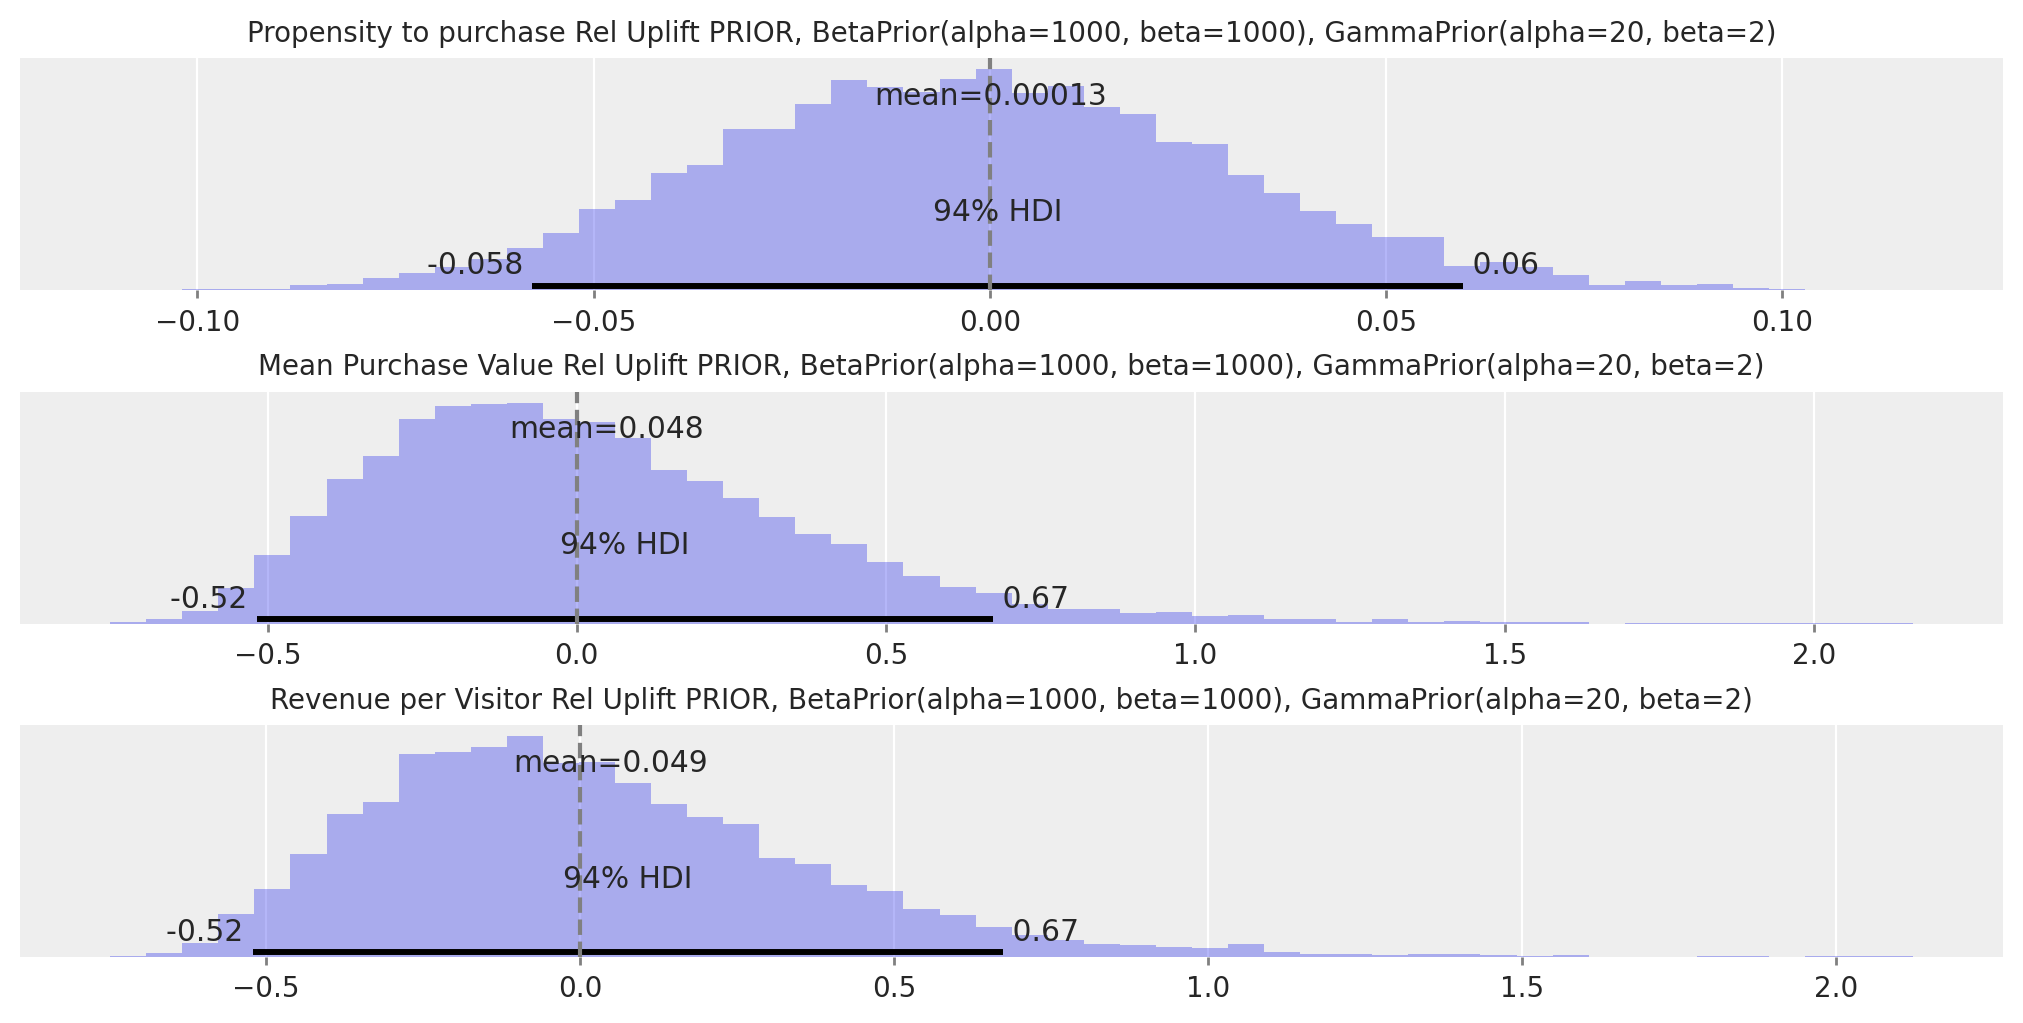

In [35]:
data = [ #making fake data. 1% of visitors make a purchase averaging $10 in revenue
    RevenueData(visitors=100, purchased=1, total_revenue=10),
    RevenueData(visitors=100, purchased=1, total_revenue=10),
]
with RevenueModel(c_prior, mp_prior).create_model(data, "best_of_rest"): # make the model
    revenue_prior_predictive = pm.sample_prior_predictive(samples=10000, return_inferencedata=False) #then sample the prior

fig, ax = plt.subplots(nrows=3,figsize=(10,5))
KPI_list = ["theta_reluplift_","reciprocal_lam_reluplift_","reluplift_"]
titles = ["Propensity to purchase Rel Uplift","Mean Purchase Value Rel Uplift","Revenue per Visitor Rel Uplift"]
for i in range(len(KPI_list)):
  az.plot_posterior(revenue_prior_predictive[KPI_list[i]+"1"], ax=ax[i], **plotting_defaults)
  ax[i].set_title(titles[i]+f" PRIOR, {c_prior}, {mp_prior}", fontsize=10)
  ax[i].axvline(x=0, color="gray",ls='dashed');

## Intuition for the about priors
#### For purchase propensity
It would be reasonable to assume that the rel. uplift for propensity, $\theta_B/\theta_A - 1 \leq 0.05$. So $\theta_B  \leq 1.05 \theta_A$. It is likely that $\theta_A \approx 0.01$ so an effective change from $\theta_B$ could be around $\theta_B \approx 0.0105$

#### For mean purchase value
Assume the company sells items between 5 and 20 dollars. Also assume prior information sets the expected mean purchase value to be around 10 dollars. Hopefully the larger "BUY NOW" button next to the higher value items would encourage shoppers to buy more expensive items. The mean purchase value would ideally increase to up to \$15. This would be a 50% increase in the mean purchase value. The corresponding prior on the relative uplift for the mean purchase value reaches up to 50%.



#### Now that priors are reasonable, let's generate some mock revenue data

In [36]:
def generate_revenue_data(
    variants: List[str],
    true_conversion_rates: List[float],
    true_mean_purchase: List[float],
    samples_per_variant: int,
) -> pd.DataFrame:
    converted = {}
    mean_purchase = {}
    for variant, p, mp in zip(variants, true_conversion_rates, true_mean_purchase):
        converted[variant] = bernoulli.rvs(p, size=samples_per_variant)
        mean_purchase[variant] = expon.rvs(scale=mp, size=samples_per_variant)
    converted = pd.DataFrame(converted)
    mean_purchase = pd.DataFrame(mean_purchase)
    revenue = converted * mean_purchase
    agg = pd.concat(
        [
            converted.aggregate(["count", "sum"]).rename(
                index={"count": "visitors", "sum": "purchased"}
            ),
            revenue.aggregate(["sum"]).rename(index={"sum": "total_revenue"}),
        ]
    )
    return agg

### Here we can combine the likelihood from the generated data with the prior information to get the posterior probability distribution of the KPI's of interest

In [37]:
def run_scenario_value(
    variants: List[str],
    true_conversion_rates: List[float],
    true_mean_purchase: List[float],
    samples_per_variant: int,
    conversion_rate_prior: BetaPrior,
    mean_purchase_prior: GammaPrior,
    comparison_method: str,
) -> az.InferenceData:
    generated = generate_revenue_data(
        variants, true_conversion_rates, true_mean_purchase, samples_per_variant
    )
    data = [RevenueData(**generated[v].to_dict()) for v in variants]
    with RevenueModel(conversion_rate_prior, mean_purchase_prior).create_model(
        data, comparison_method
    ):
        trace = pm.sample(draws=5000, chains=2, cores=1)

    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8, 4))
    az.plot_posterior(trace.posterior[f"theta_reluplift_1"], ax=ax[0], **plotting_defaults)
    ax[0].set_title(f"Purchase Propensity Rel Uplift",fontsize=10)
    tcr_rel_uplift = true_conversion_rates[1]/true_conversion_rates[0]-1
    ax[0].axvline(x=tcr_rel_uplift, ls='dashed', color="red",label='True uplift')
    ax[0].axvline(x=np.mean(trace.posterior[f"theta_reluplift_1"]), ls='dashed', color="blue",label='Predicted uplift')
    ax[0].axvline(x=0, ls='dashed', color="gray",label='No uplift')

    az.plot_posterior(trace.posterior[f"reciprocal_lam_reluplift_1"], ax=ax[1], **plotting_defaults)
    ax[1].set_title(f"Mean Purchase Amount Rel Uplift",fontsize=10)
    tmp_rel_uplift = true_mean_purchase[1]/true_mean_purchase[0]-1
    ax[1].axvline(x=tmp_rel_uplift, ls='dashed', color="red",label='True uplift')
    ax[1].axvline(x=np.mean(trace.posterior[f"reciprocal_lam_reluplift_1"]), ls='dashed', color="blue",label='Predicted uplift')
    ax[1].axvline(x=0, ls='dashed', color="gray",label='No uplift')


    az.plot_posterior(trace.posterior[f"reluplift_1"], ax=ax[2], **plotting_defaults)
    rpv_A = true_conversion_rates[0] * true_mean_purchase[0]
    rpv_B = true_conversion_rates[1] * true_mean_purchase[1]
    ax[2].set_title(f"Revenue Per Visitor (RPV) Rel Uplift",fontsize=10)
    ax[2].axvline(x=rpv_B/rpv_A-1, ls='dashed', color="red",label='True uplift')
    ax[2].axvline(x=np.mean(trace.posterior[f"reluplift_1"]), ls='dashed', color="blue",label='Predicted uplift')
    ax[2].axvline(x=0, ls='dashed', color="gray",label='No uplift')
    ax[2].legend(fontsize=10)
    return trace

### Finally we can use pyMC to sample the posterior distribution

We will be using three scenarios to help get a handle on the amount of samples we would want to get a reliable result. All scenarios will use simulated data that increases the conversion rate by 5% and the mean purchase amount by 10% when comparing the B variant to the A variant.

The first scenario, we'll call it the fiducial scenario, there are 100,000 samples per variant.

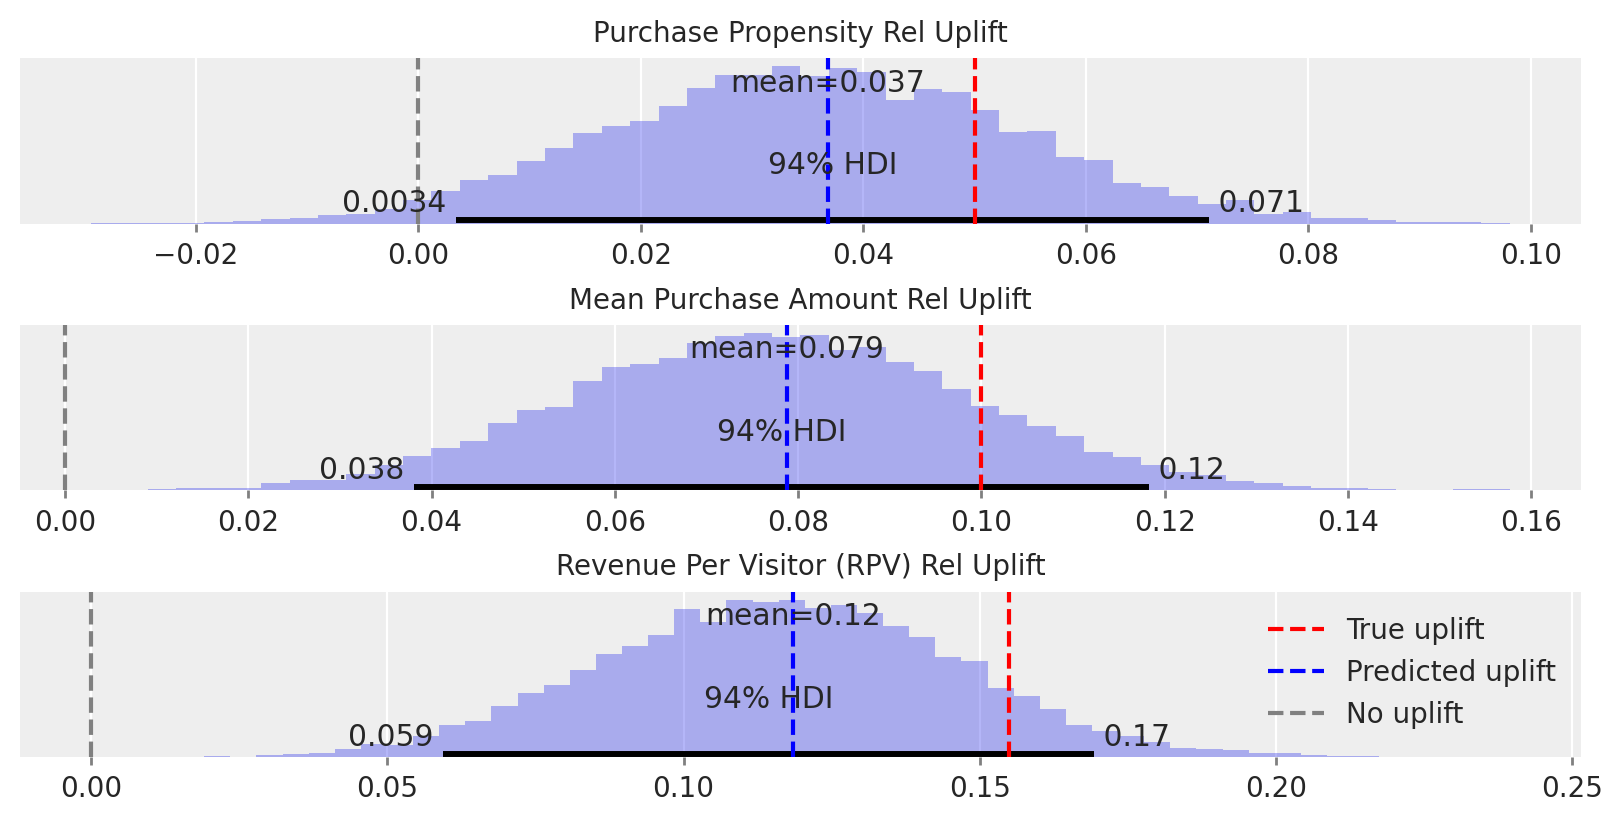

In [38]:
scenario_value = run_scenario_value(
    variants=["A", "B"],
    true_conversion_rates=[0.05, 0.0525],
    true_mean_purchase=[10, 11],
    samples_per_variant=100_000,
    conversion_rate_prior=BetaPrior(alpha=alpha_B, beta=beta_B),
    mean_purchase_prior=GammaPrior(alpha=alpha_G, beta=beta_G),
    comparison_method="compare_to_control",
)

In the fiducial scenario, the 94% high density interval (HDI) for the relative uplift is above zero for the three KPI's that we tested. **This means that 100,000 samples per variant would be enough samples that we could confidently say that variant B is better than A** (in context of these KPI's).

One can also notice that the true uplift is within the HDI (which is good) but it seems that the prediction underestimates the true uplift for all three metrics. This is likely due to the predicted uplift being pulled down by the prior. This problem can be alleviated by using more samples or a more specific prior.

### Increasing samples per variant to 1,000,000

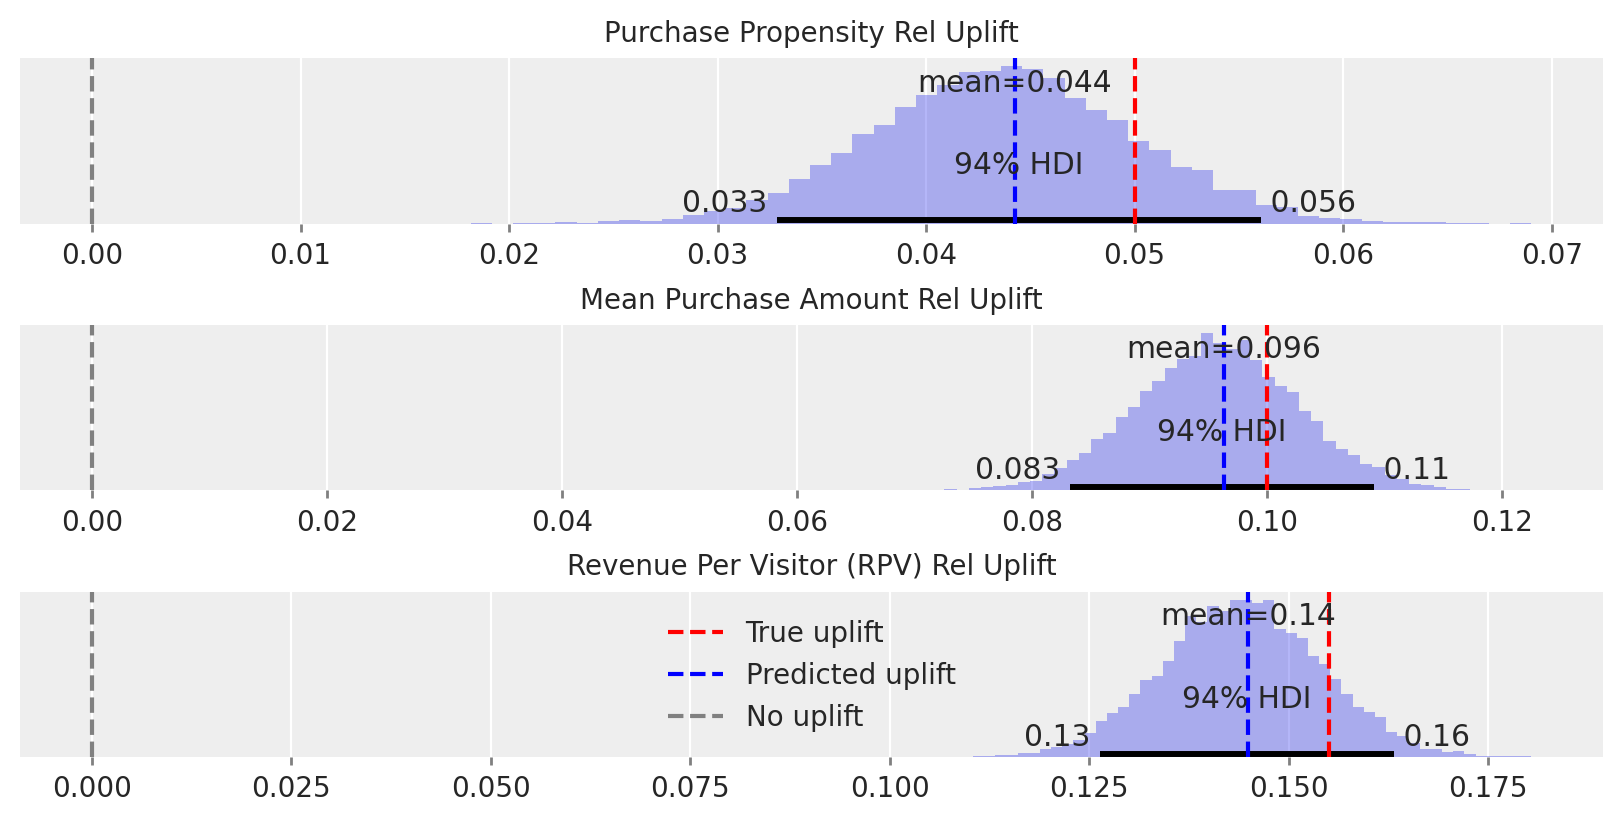

In [44]:
scenario_value = run_scenario_value(
    variants=["A", "B"],
    true_conversion_rates=[0.05, 0.0525],
    true_mean_purchase=[10, 11],
    samples_per_variant=100000*10,
    conversion_rate_prior=BetaPrior(alpha=alpha_B, beta=beta_B),
    mean_purchase_prior=GammaPrior(alpha=alpha_G, beta=beta_G),
    comparison_method="compare_to_control",
)

As one would expect, the bounds of the HDI is well above 0 so this result again so we have enough samples to confidently say that variant B is better than A. But notice that the HDI is much more compact than the previous case and that the predicted uplift is much closer to the true uplift. This is what we expect because more samples allows the influence of more data to overpower the prior.

### Decreasing samples per variant to 10,000

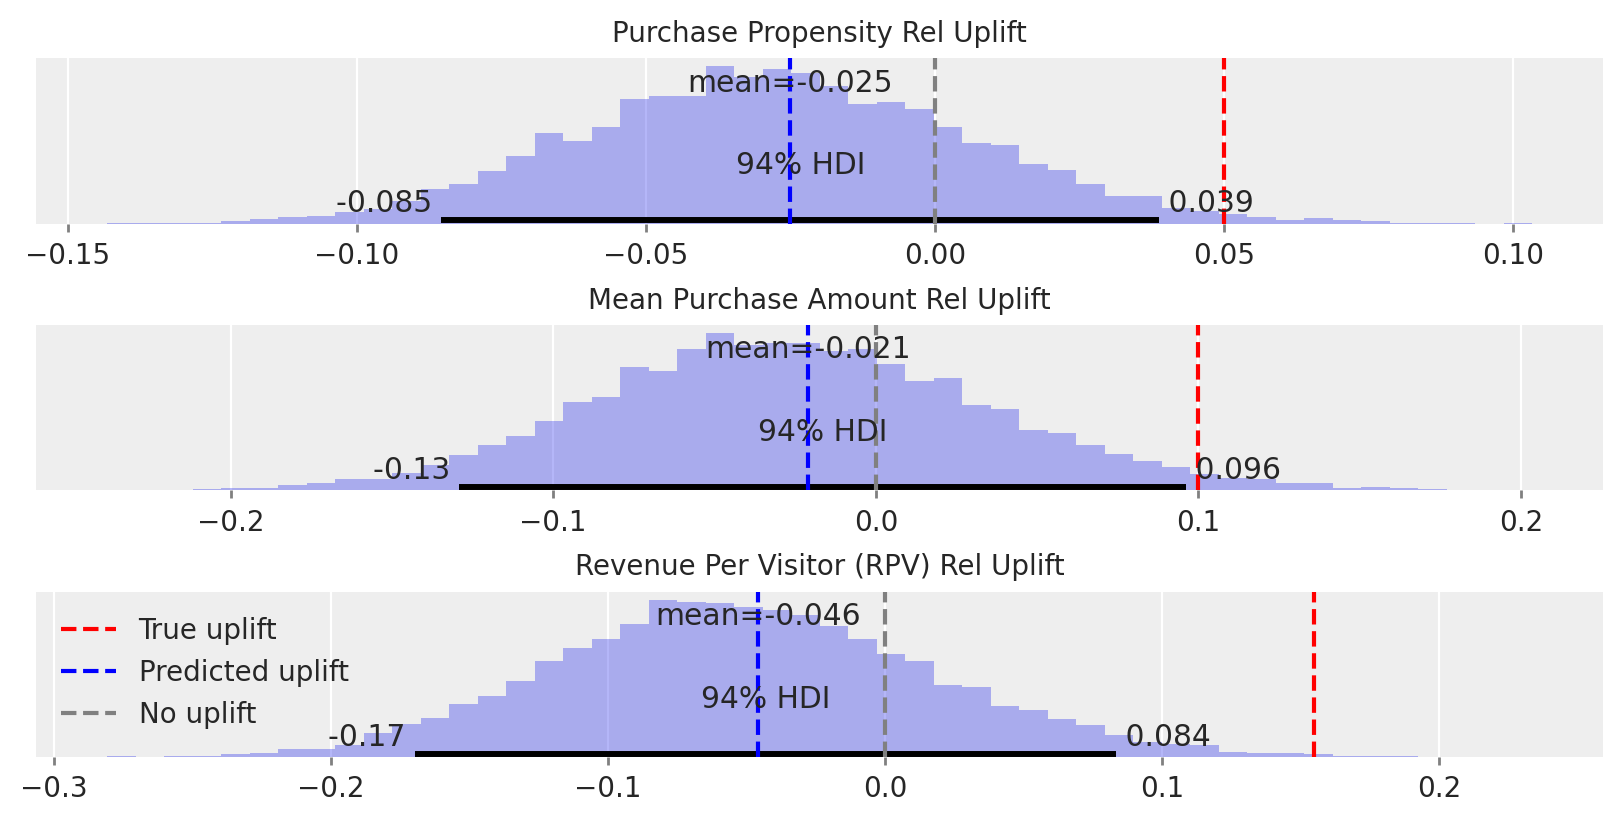

In [41]:
scenario_value = run_scenario_value(
    variants=["A", "B"],
    true_conversion_rates=[0.05, 0.0525],
    true_mean_purchase=[10, 11],
    samples_per_variant=int(100000/10),
    conversion_rate_prior=BetaPrior(alpha=alpha_B, beta=beta_B),
    mean_purchase_prior=GammaPrior(alpha=alpha_G, beta=beta_G),
    comparison_method="compare_to_control",
)

By decreasing the samples per variant to 10,000, it is clear that this is not enough sample to confidently measure the effectiveness of the new variant. In fact, the mean relative uplift of all three of the metrics are below 0 which is in the wrong direction! We must use more samples per variant in order to use Bayesian A/B testing.

# Summary of project
In this hypothetical project, I simulated data for an A/B test and then used Bayesian inference to see if a larger "BUY NOW" button can improve 3 key performance indicators: conversion rate, mean purchase amount, and revenue per visitor.

### Caveats
- I made an educated guess for what the prior should be but I would need more domain knowledge on the subject to improve this guess
- There is no guarantee that the distributions are exactly correct. In particular, we do not include the effects of outliers.

### Main takeaways

- Bayesian A/B testing methodologies can be useful to quantifiably say whether or not the B variant improved KPI's
- It seems that 100,000 samples per variant is enough such that the 94% HDI is above zero in the relative uplift distributions for the three KPI's. Additionally, for the RPV relative uplift, we can use the HDI to say that there is a 94% chance that the new variant increased the RPV by 6-17% (true value is 16%).